In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import os
import sys

In [2]:
sys.path.append(os.path.abspath('../scripts'))

In [3]:
from time_series import *

## Loading the data

In [4]:
df = pd.read_csv('../data/tsla.csv')

### making the date column as index

In [5]:
df['Date'] = pd.to_datetime(df['Date'])  
df.set_index('Date', inplace=True)     

## Splitting the data into training and testing sets

In [6]:
train, test = split_data(df['Close'])

2024-11-13 16:09:58,320 - INFO - Data split into train and test sets successfully.


### choosing the best parameter for SARIMA model

In [7]:
# Seasonal auto_arima to find the best parameters
stepwise_model = auto_arima(train, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)
print(stepwise_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=14.90 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=12376.818, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=12375.531, Time=0.85 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=12376.009, Time=1.32 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=12375.317, Time=0.08 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=12376.983, Time=0.92 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=12377.355, Time=0.96 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=12369.981, Time=1.98 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=12348.776, Time=5.22 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=12346.777, Time=2.64 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=12345.613, Time=3.24 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=12347.601, Time=6.87 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=12368.841, Time=2.57 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=12346.729, Time=4.97 sec
 ARIMA(1,1

## Training SARIMA model

In [9]:
# Use the best parameters from auto_arima
p, d, q = stepwise_model.order
P, D, Q, m = stepwise_model.seasonal_order

# Fit the SARIMA model
sarima_model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, m), enforce_stationarity=False, enforce_invertibility=False)
sarima_result = sarima_model.fit(disp=False)


c:\Time-Series-Portfolio-Optimization\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Time-Series-Portfolio-Optimization\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## Forecasting the Test Set

c:\Time-Series-Portfolio-Optimization\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Time-Series-Portfolio-Optimization\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


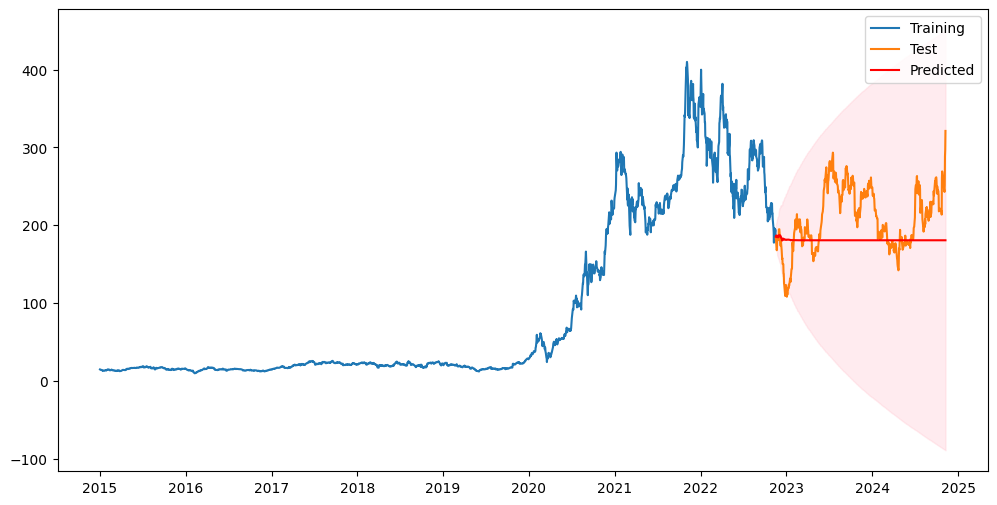

In [10]:
# Forecast for the test period
forecast = sarima_result.get_forecast(steps=len(test))
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot the forecasted vs actual values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Training")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, predicted_mean, label="Predicted", color="red")
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.show()

## Evaluating the Model

In [11]:
# Calculate evaluation metrics
mae = mean_absolute_error(test, predicted_mean)
rmse = np.sqrt(mean_squared_error(test, predicted_mean))
mape = mean_absolute_percentage_error(test, predicted_mean)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")


Mean Absolute Error (MAE): 38.48307030501455
Root Mean Squared Error (RMSE): 48.55506701017008
Mean Absolute Percentage Error (MAPE): 0.17451260686558123


## Forecasting (12 months)

In [12]:
# Number of steps to forecast (6 months or 12 months, assuming monthly data)
forecast_steps = 12  # You can change this to 6 for 6 months

# Generate forecast for the specified steps ahead
forecast_future = sarima_result.get_forecast(steps=forecast_steps)
predicted_mean_future = forecast_future.predicted_mean
conf_int_future = forecast_future.conf_int()

# Print the forecasted future values
print(predicted_mean_future)


1984    185.084267
1985    186.581617
1986    186.699661
1987    186.727076
1988    184.537730
1989    185.307471
1990    184.524592
1991    186.323724
1992    186.752626
1993    186.675204
1994    187.212491
1995    186.883153
Name: predicted_mean, dtype: float64


c:\Time-Series-Portfolio-Optimization\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Time-Series-Portfolio-Optimization\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


## Forecast Analysis - Visualization

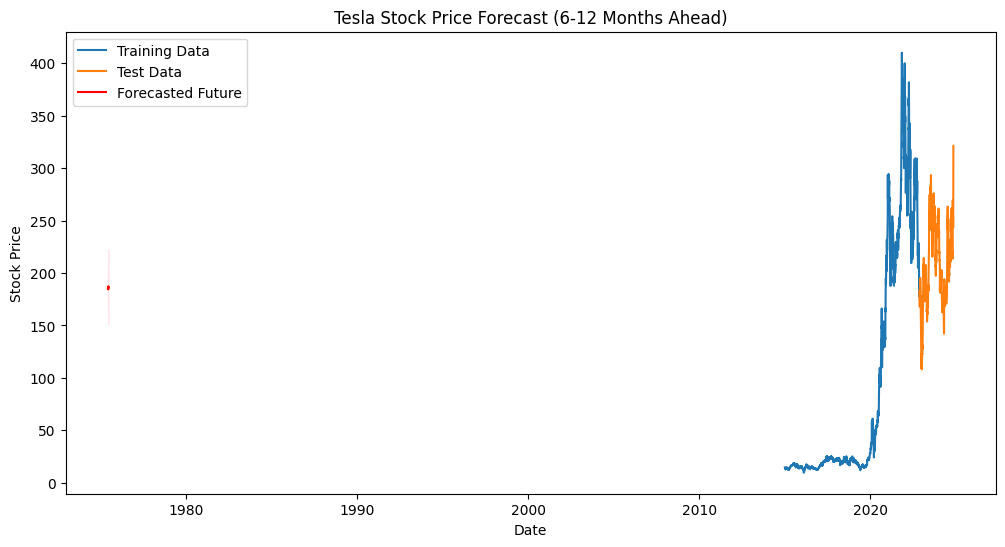

In [13]:
# Plot the historical data along with the forecasted data
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Training Data")
plt.plot(test.index, test, label="Test Data")
plt.plot(predicted_mean_future.index, predicted_mean_future, label="Forecasted Future", color="red")
plt.fill_between(predicted_mean_future.index, conf_int_future.iloc[:, 0], conf_int_future.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Tesla Stock Price Forecast (6-12 Months Ahead)")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


# Forecasting the the stock price of SYN and BND 

In [14]:
df_spy = pd.read_csv('../data/spy.csv')
df_bnd = pd.read_csv('../data/bnd.csv')

In [15]:
train_spy, test_spy = split_data(df_spy['Close'])
train_bnd, test_bnd = split_data(df_bnd['Close'])

2024-11-13 16:11:52,407 - INFO - Data split into train and test sets successfully.
2024-11-13 16:11:52,411 - INFO - Data split into train and test sets successfully.


In [16]:
# Seasonal auto_arima to find the best parameters
stepwise_model_spy = auto_arima(train_spy, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)
print(stepwise_model_spy.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=10402.546, Time=12.02 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=10493.069, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=10477.506, Time=0.46 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=10479.278, Time=1.48 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=10493.001, Time=0.07 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=10400.536, Time=9.55 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=10399.175, Time=3.23 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=10400.515, Time=9.01 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=10475.080, Time=0.81 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=10475.391, Time=0.36 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=10464.127, Time=3.95 sec
 ARIMA(2,1,3)(0,0,0)[12] intercept   : AIC=10466.295, Time=4.18 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=10474.666, Time=0.49 sec
 ARIMA(1,1,3)(0,0,0)[12] intercept   : AIC=10475.630, Time=1.80 sec
 ARI

In [ ]:
# Seasonal auto_arima to find the best parameters
stepwise_model_bnd = auto_arima(train_bnd, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)
print(stepwise_model_bnd.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-223.458, Time=8.16 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-176.784, Time=0.22 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-184.460, Time=1.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-183.356, Time=1.57 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-178.602, Time=0.12 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-220.426, Time=5.72 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-221.006, Time=6.42 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=-223.193, Time=28.46 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-223.249, Time=26.67 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-217.988, Time=2.73 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=-225.128, Time=14.15 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=-205.031, Time=10.72 sec
 ARIMA(2,1,1)(0,0,2)[12] intercept   : AIC=-207.996, Time=10.96 sec
 ARIMA(3,1,2)(0,0,2)[12] intercept   : AIC=-221.995, Time=23.34 sec
 ARIMA(2,1,3)

In [17]:
# Use the best parameters from auto_arima
p, d, q = stepwise_model_spy.order
P, D, Q, m = stepwise_model_spy.seasonal_order

# Fit the SARIMA model
sarima_model_spy = SARIMAX(train_spy, order=(p, d, q), seasonal_order=(P, D, Q, m), enforce_stationarity=False, enforce_invertibility=False)
sarima_result_spy = sarima_model_spy.fit(disp=False)


In [18]:
# Use the best parameters from auto_arima
p, d, q = stepwise_model.order
P, D, Q, m = stepwise_model.seasonal_order

# Fit the SARIMA model
sarima_model_bnd = SARIMAX(train_bnd, order=(p, d, q), seasonal_order=(P, D, Q, m), enforce_stationarity=False, enforce_invertibility=False)
sarima_result_bnd = sarima_model_bnd.fit(disp=False)


## Forecasting based on the test data

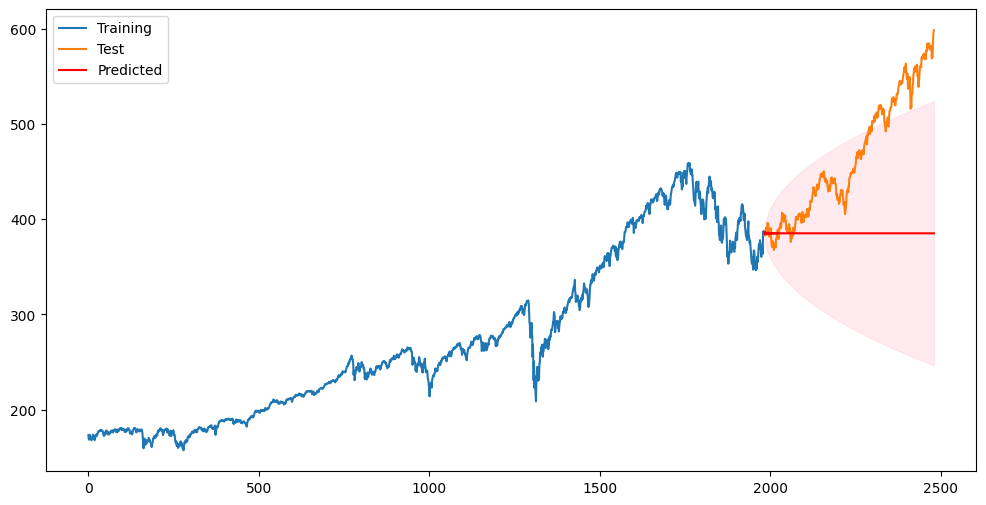

In [19]:
# Forecast for the test period
forecast_spy = sarima_result_spy.get_forecast(steps=len(test_spy))
predicted_mean_spy = forecast_spy.predicted_mean
conf_int_spy = forecast_spy.conf_int()

# Plot the forecasted vs actual values
plt.figure(figsize=(12, 6))
plt.plot(train_spy.index, train_spy, label="Training")
plt.plot(test_spy.index, test_spy, label="Test")
plt.plot(test_spy.index, predicted_mean_spy, label="Predicted", color="red")
plt.fill_between(test_spy.index, conf_int_spy.iloc[:, 0], conf_int_spy.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.show()

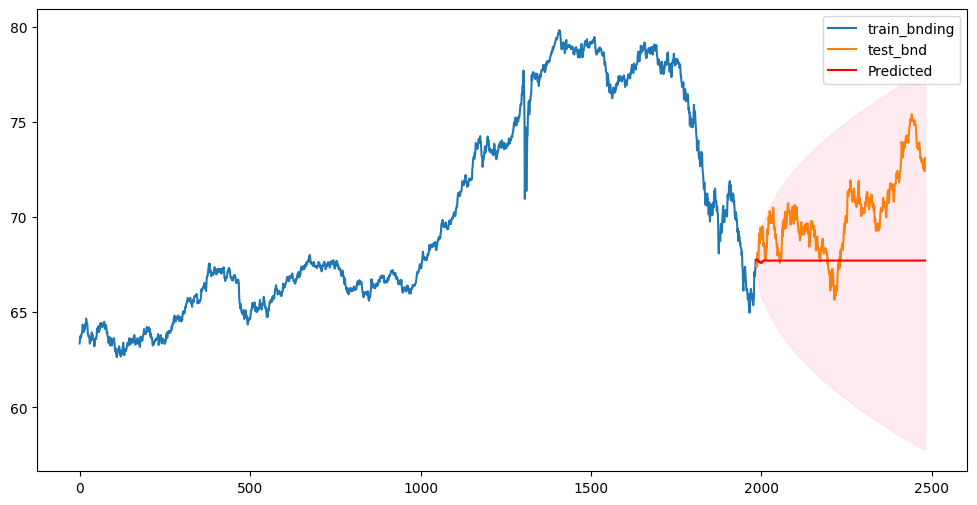

In [25]:
# forecast_bnd for the test_bnd period
forecast_bnd = sarima_result_bnd.get_forecast(steps=len(test_bnd))
predicted_mean_bnd = forecast_bnd.predicted_mean
conf_int_bnd = forecast_bnd.conf_int()

# Plot the forecast_bnded vs actual values
plt.figure(figsize=(12, 6))
plt.plot(train_bnd.index, train_bnd, label="train_bnding")
plt.plot(test_bnd.index, test_bnd, label="test_bnd")
plt.plot(test_bnd.index, predicted_mean, label="Predicted", color="red")
plt.fill_between(test_bnd.index, conf_int_bnd.iloc[:, 0], conf_int_bnd.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.show()

## Evaluation

In [23]:
# Calculate evaluation metrics
mae_spy = mean_absolute_error(test_spy, predicted_mean_spy)
rmse_spy = np.sqrt(mean_squared_error(test_spy, predicted_mean_spy))
mape_spy = mean_absolute_percentage_error(test_spy, predicted_mean_spy)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")


Mean Absolute Error (MAE): 38.48307030501455
Root Mean Squared Error (RMSE): 48.55506701017008
Mean Absolute Percentage Error (MAPE): 0.16019261784876543


In [26]:
# Calculate evaluation metrics
mae_bnd = mean_absolute_error(test_bnd, predicted_mean_bnd)
rmse_bnd = np.sqrt(mean_squared_error(test_bnd, predicted_mean_bnd))
mape_bnd = mean_absolute_percentage_error(test_bnd, predicted_mean_bnd)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")


Mean Absolute Error (MAE): 38.48307030501455
Root Mean Squared Error (RMSE): 48.55506701017008
Mean Absolute Percentage Error (MAPE): 0.16019261784876543


## Forecasting 

In [28]:
# Number of steps to forecast (6 months or 12 months, assuming monthly data)
forecast_steps = 12  # You can change this to 6 for 6 months

# Generate forecast for the specified steps ahead
forecast_future_spy = sarima_result_spy.get_forecast(steps=forecast_steps)
predicted_mean_future_spy = forecast_future_spy.predicted_mean
conf_int_future_spy = forecast_future_spy.conf_int()

# Print the forecasted future values
print(predicted_mean_future_spy)


1984    386.136936
1985    384.055108
1986    385.940270
1987    384.465888
1988    385.390464
1989    385.070546
1990    384.812678
1991    385.552138
1992    384.476893
1993    385.716236
1994    384.486020
1995    385.554193
Name: predicted_mean, dtype: float64


In [29]:
# Number of steps to forecast (6 months or 12 months, assuming monthly data)
forecast_steps = 12  # You can change this to 6 for 6 months

# Generate forecast for the specified steps ahead
forecast_future_bnd = sarima_result_bnd.get_forecast(steps=forecast_steps)
predicted_mean_future_bnd = forecast_future_bnd.predicted_mean
conf_int_future_bnd = forecast_future_bnd.conf_int()

# Print the forecasted future values
print(predicted_mean_future_bnd)


1984    67.733805
1985    67.748878
1986    67.775479
1987    67.745352
1988    67.740734
1989    67.725240
1990    67.713370
1991    67.645810
1992    67.659685
1993    67.693926
1994    67.652412
1995    67.613156
Name: predicted_mean, dtype: float64


## Forecast Analysis - Visualization

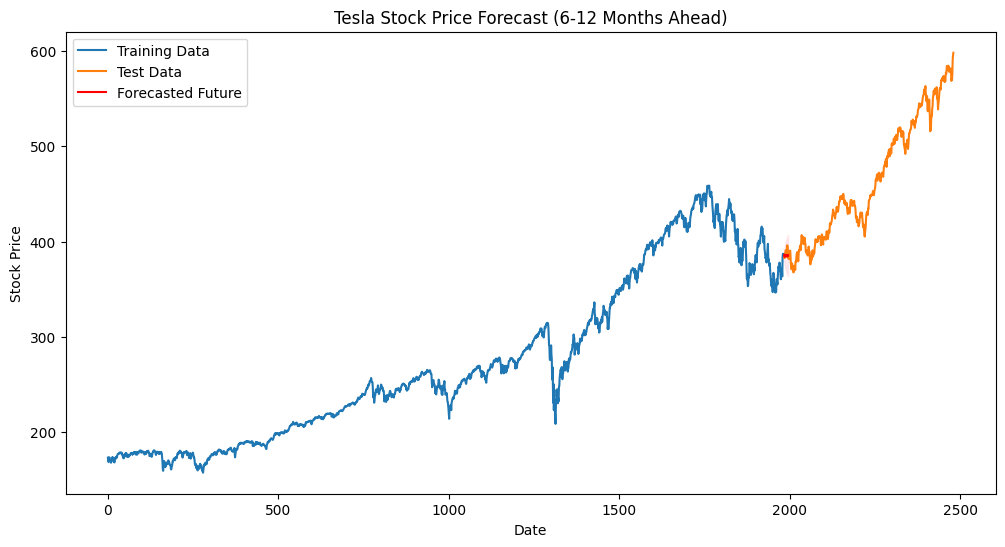

In [30]:
# Plot the historical data along with the forecasted data
plt.figure(figsize=(12, 6))
plt.plot(train_spy.index, train_spy, label="Training Data")
plt.plot(test_spy.index, test_spy, label="Test Data")
plt.plot(predicted_mean_future_spy.index, predicted_mean_future_spy, label="Forecasted Future", color="red")
plt.fill_between(predicted_mean_future_spy.index, conf_int_future_spy.iloc[:, 0], conf_int_future_spy.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Tesla Stock Price Forecast (6-12 Months Ahead)")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


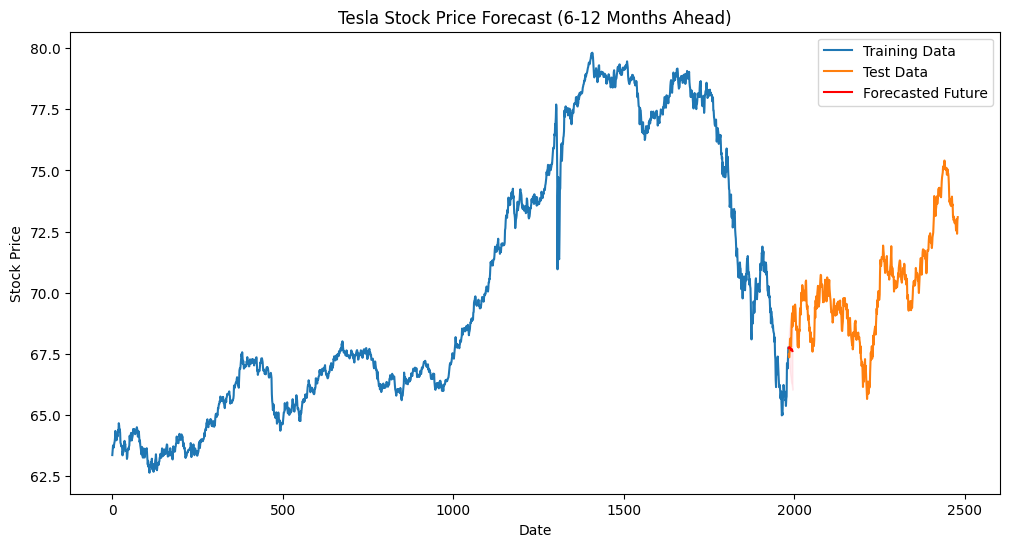

In [31]:
# Plot the historical data along with the forecasted data
plt.figure(figsize=(12, 6))
plt.plot(train_bnd.index, train_bnd, label="Training Data")
plt.plot(test_bnd.index, test_bnd, label="Test Data")
plt.plot(predicted_mean_future_bnd.index, predicted_mean_future_bnd, label="Forecasted Future", color="red")
plt.fill_between(predicted_mean_future_bnd.index, conf_int_future_bnd.iloc[:, 0], conf_int_future_bnd.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Tesla Stock Price Forecast (6-12 Months Ahead)")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()
